# Data simulation
> close-to-real data simulation notebook with visualization

Problem: parameters for data generation really impact on the quality
of the data. Poor quality dataset lead to bad or, in general, unexpected
results which might confound inference tests.

Solution: with this notebook we guide through the possible data simulations
so to get good quality simulated data with various desired properties.

## From real datasets

First we observe one real dataset and use it as a reference.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import anndata
import scgenome.plotting as pl

file_path = "/Users/zemp/Downloads/data/signals_SPECTRUM-OV-006.h5"
ad = anndata.read_h5ad(file_path)
ad.shape

(1314, 6206)

### Counts
This dataset features 1314 single cells and 6206 bins that are 500k wide.

In [3]:
import numpy as np
filter_nan_mask = ~np.isnan(ad.layers['copy'])
corr_counts = ad.layers['copy'][filter_nan_mask]

print(f"min: {corr_counts.min()}, max: {corr_counts.max()}, mean: {corr_counts.mean()}")

min: 0.0017087818494337, max: 13.0476933930879, mean: 1.9512576680476768


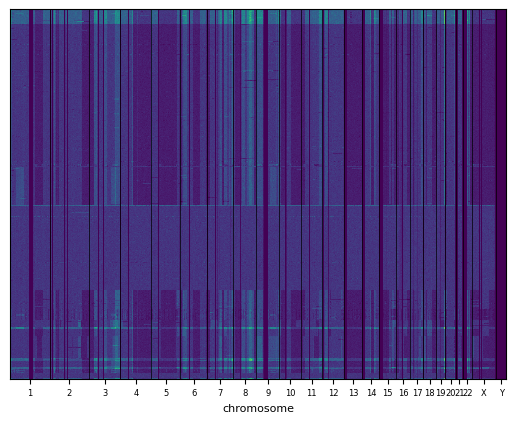

In [4]:
g = pl.plot_cell_cn_matrix(ad, layer_name='copy', raw=True, cell_order_fields=['cluster_id'])

### Clones

The number of clusters (subclones) is 25, but many contain only one or very few cells.
Only 6 clones have prevalence larger than 50 (cells).

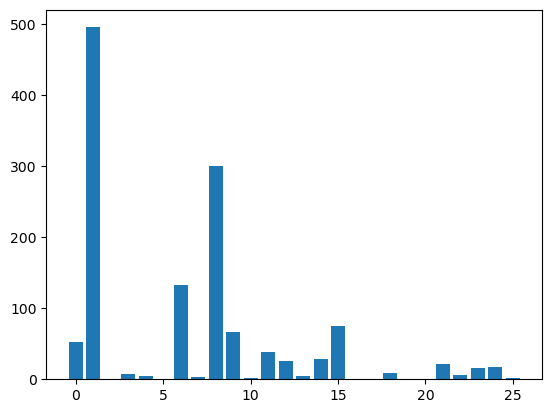

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
val, counts = np.unique(ad.obs['cluster_id'], return_counts=True)
g = plt.bar(val, counts)

In [6]:
clone_thresh = 50
print(f"Number of clones with less than {clone_thresh} cells: {np.sum(counts > clone_thresh)}")

Number of clones with less than 50 cells: 6


### Copy number changes

If we discard normal cells, the copy number changes (here called by HMMCopy)
represent the 2% of the bins on average for each cell.

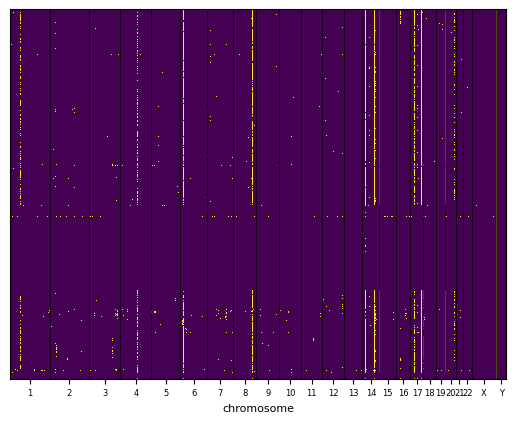

In [7]:
cn_matrix = ad.layers['state']
diff_matrix = np.abs(cn_matrix - np.roll(cn_matrix, axis=1, shift=1)) > 0
ad.layers['diff'] = diff_matrix
g = pl.plot_cell_cn_matrix(ad, layer_name='diff', raw=True, cell_order_fields=['cluster_id'])

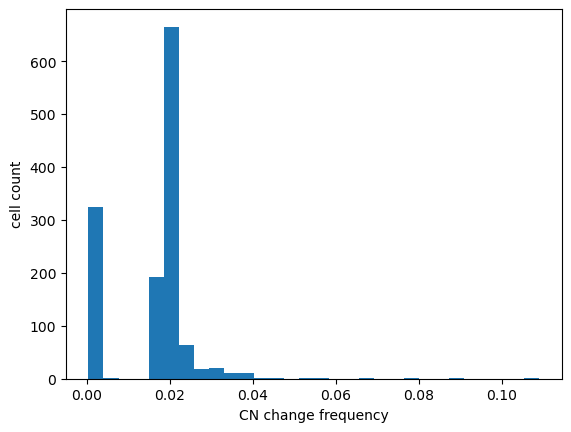

In [8]:
plt.hist(diff_matrix.sum(axis=1) / ad.n_vars, bins=30)
ax = plt.gca()
ax.set_xlabel('CN change frequency')
ax.set_ylabel('cell count');

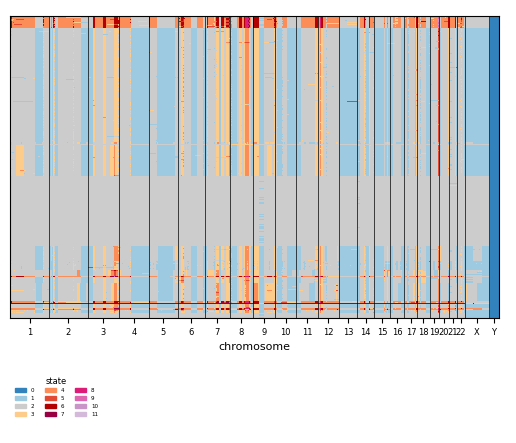

In [9]:
g = pl.plot_cell_cn_matrix_fig(ad, layer_name='state', cell_order_fields=['cluster_id'])

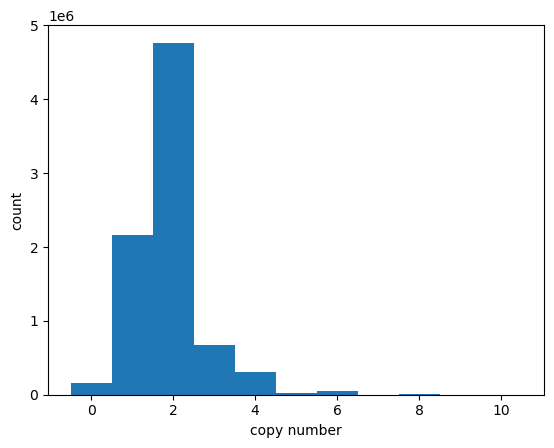

In [10]:
plt.hist(cn_matrix.flatten(), bins=np.arange(cn_matrix.max() + 1) - 0.5)
ax = plt.gca()
ax.set_ylabel('count')
ax.set_xlabel('copy number');

In [11]:
cn_thresh = 6
print(f"Entries in cn-matrix with CN higher than {cn_thresh}: {np.mean(cn_matrix > cn_thresh) * 100:.3f}%")

Entries in cn-matrix with CN higher than 6: 0.109%


### Baseline


In [12]:
filt_cn = cn_matrix[filter_nan_mask]
no_zero_cn_mask = filt_cn != 0  # avoid division by 0
baseline_matrix = (corr_counts / filt_cn)[no_zero_cn_mask]
print(f"mean: {np.mean(baseline_matrix)}, precision: {1 / np.var(baseline_matrix)}, sd: {np.sqrt(np.var(baseline_matrix))}")  # mean and precision

mean: 1.0005873663813294, precision: 49.1447310388086, sd: 0.14264663089289323


#### On zero-cn counts
Counts associated to total copy loss are no less than 0.0017, with an average of 0.052 and variance 0.013

In [13]:
print(f"[Zero CN counts stats] min: {corr_counts[~no_zero_cn_mask].min()}, mean: {corr_counts[~no_zero_cn_mask].mean()}, sd: {np.sqrt(corr_counts[~no_zero_cn_mask].var())}")

[Zero CN counts stats] min: 0.0017087818494337, mean: 0.051819701849519, sd: 0.11390739263725207


## To synthetic data

Here we generate a dataset with similar features

In [15]:
from simul import generate_chromosome_binning, simulate_full_dataset
from utils.config import Config

n_cells = 1000
n_bins = 6000  # actual number of bins will change slightly after simulating the dataset, use config.chain_length
n_clones = 6
max_cn = 6
config = Config(n_cells=n_cells, chain_length=n_bins, n_nodes=n_clones, n_states=max_cn + 1)

chr_df = generate_chromosome_binning(n_bins, method='real')
data = simulate_full_dataset(config, chr_df=chr_df,
                             eps_a=80., eps_b=40000., mu0=1., lambda0=3., alpha0=2500., beta0=50.,
                             cne_length_factor=300, dir_delta=5.)  # params
sim_ad = data['adata']

In [16]:
sim_corr_counts = sim_ad.layers['copy']
print(f"min: {sim_corr_counts.min()}, max: {sim_corr_counts.max()}, mean: {sim_corr_counts.mean()}")

min: 0.0, max: 7.880334377288818, mean: 2.314570426940918


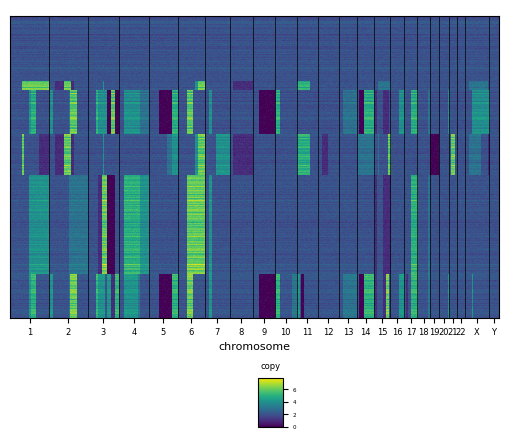

In [17]:
%matplotlib inline
g = pl.plot_cell_cn_matrix_fig(sim_ad, layer_name='copy', raw=True, cell_order_fields=['clone'])

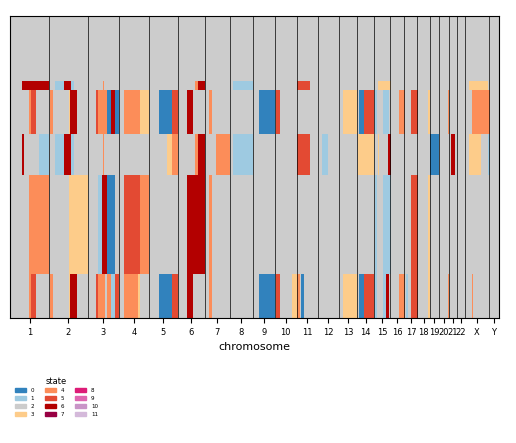

In [18]:
g = pl.plot_cell_cn_matrix_fig(sim_ad, layer_name='state', cell_order_fields=['clone'])

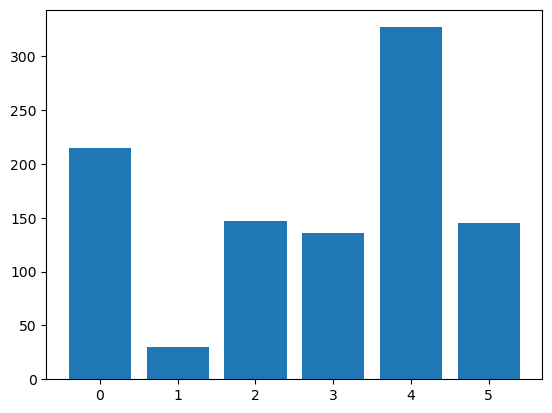

In [19]:
# Clones
val, counts = np.unique(sim_ad.obs['clone'], return_counts=True)
g = plt.bar(val, counts)

We can see that the amount of copy number changes is lower than real data, but this is probably due to the
fact that copy number signal is much more stable than that in HMMCopy, for which we can observe various smaller CN events.
In general, we can assume that clonal copy number is less noisy than subclonal/cell-specific copy number.

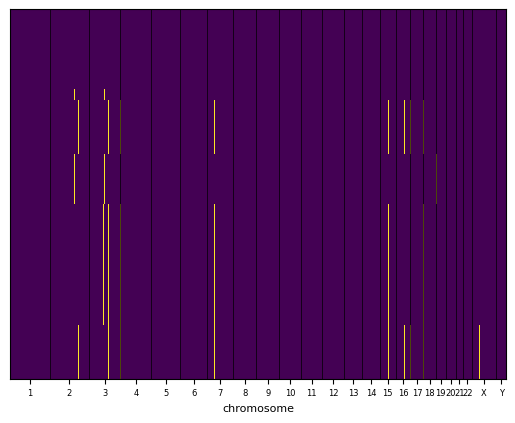

In [20]:
# copy number changes
cn_matrix = sim_ad.layers['state']
diff_matrix = np.abs(cn_matrix - np.roll(cn_matrix, axis=1, shift=1)) > 0
sim_ad.layers['diff'] = diff_matrix
g = pl.plot_cell_cn_matrix(sim_ad, layer_name='diff', raw=True, cell_order_fields=['clone'])

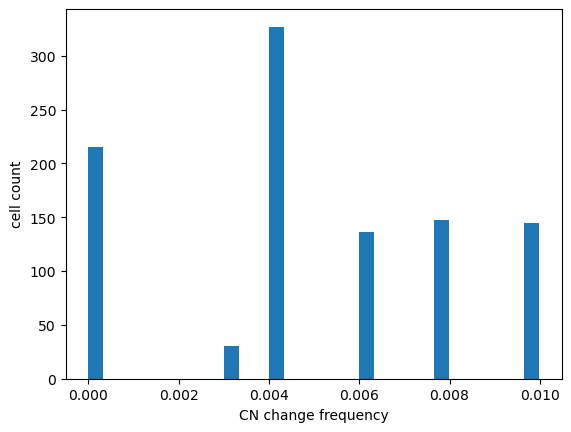

In [21]:
plt.hist(diff_matrix.sum(axis=1) / ad.n_vars, bins=30)
ax = plt.gca()
ax.set_xlabel('CN change frequency')
ax.set_ylabel('cell count');

Another evident difference is that the copy number is much more skewed towards 2. In particular,
we observe that all other copy numbers are more or less equally present. This happens due to our model
which gives same probability mass to any copy number state when transitioning. This should be considered just a
data generation issue but should not impact inference too much. However, it would be desirable to observe a less
peaked histogram, without the copy number profile being too shattered.

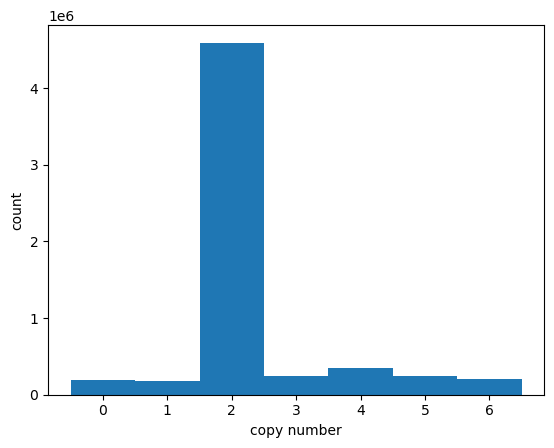

In [22]:
plt.hist(cn_matrix.flatten(), bins=np.arange(config.n_states + 1) - 0.5)
ax = plt.gca()
ax.set_ylabel('count')
ax.set_xlabel('copy number');

### Baseline
Here the baseline show larger precision than the real data.

In [23]:
# baseline
print(f"mean: {np.mean(sim_ad.obs['baseline'])}, precision: {1 / np.var(sim_ad.obs['baseline'])}, sd: {np.sqrt(np.var(sim_ad.obs['baseline']))}")  # mean and precision

mean: 0.9966521859169006, precision: 155.5149795920791, sd: 0.08018883317708969


### Zero-counts
These statistics are similar to the ones from the real data.

In [24]:
no_zero_cn_mask = sim_ad.layers['state'] != 0
print(f"[Zero CN counts stats] min: {sim_ad.layers['copy'][~no_zero_cn_mask].min()}, mean: {sim_ad.layers['copy'][~no_zero_cn_mask].mean()}, sd: {np.sqrt(sim_ad.layers['copy'][~no_zero_cn_mask].var())}")

[Zero CN counts stats] min: 0.0, mean: 0.056321825832128525, sd: 0.0825842097401619


## VICTree test
> run victree with defaults

In [34]:
from inference.victree import make_input, VICTree
from variational_distributions.joint_dists import FixedTreeJointDist
from utils.config import set_seed

set_seed(5)
cfg, q, dh = make_input(sim_ad, fix_tree=data['tree'])
cfg.step_size = .3

In [35]:
isinstance(q, FixedTreeJointDist)

True

In [36]:
vic = VICTree(config=cfg, q=q, data_handler=dh)
vic.run()

 10%|█         | 2/20 [00:32<04:56, 16.46s/it, elbo=-2.29e+8, diff=0.000%]


In [ ]:
res_ad = dh.get_anndata()
res_ad.obs['clone'] = vic.q.z.pi.argmax(dim=1).numpy()
res_ad.obs['clone-gt'] = sim_ad.obs['clone']
res_ad.obs['baseline'] = vic.q.mt.nu.numpy()
res_ad.layers['viterbi'] = vic.q.c.get_viterbi()[res_ad.obs['clone']].numpy()

pl.plot_cell_cn_matrix_fig(res_ad, layer_name='viterbi', max_cn=config.n_states-1, cell_order_fields=['clone'], annotation_fields=['baseline', 'clone', 'clone-gt']);

In [ ]:
vic.q.c.get_viterbi().numpy()

## Test dataset
> one chromosome, simpler

In [ ]:
from utils.tree_utils import tree_to_newick

config = Config(n_nodes=5, n_cells=300, chain_length=1000, step_size=.2, debug=True)
data = simulate_full_dataset(config,
                             eps_a=10., eps_b=4000., mu0=1., lambda0=3., alpha0=2500., beta0=50.,
                             cne_length_factor=200, dir_delta=10.)  # params
sim_ad = data['adata']
print(tree_to_newick(data['tree']))

In [ ]:
from utils.visualization_utils import plot_cn_matrix, plot_obs
g = plot_cn_matrix(data['c'], data['z'])

In [ ]:
g = plot_obs(data['obs'], data['z'])